Memuat dan memproses data Fashion-MNIST...
29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

--- Mulai Pelatihan VAE ---
Pelatihan VAE Selesai.

--- Mulai Pelatihan Standard Autoencoder ---
Pelatihan Standard Autoencoder Selesai.

--- Visualisasi Latent Space VAE ---
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


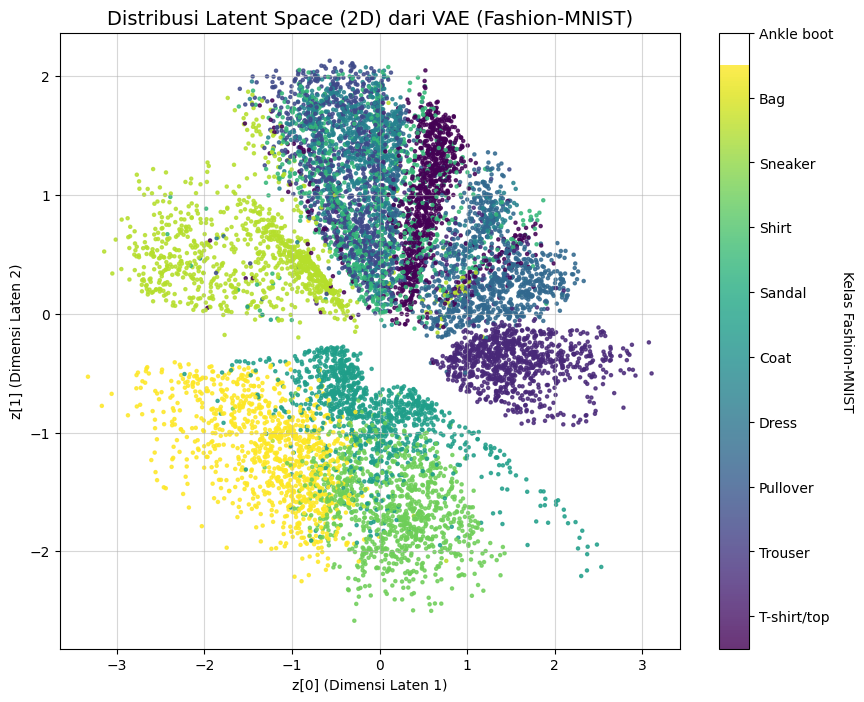


--- Latent Space Arithmetic (Penjumlahan Vektor di Ruang Laten) ---
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


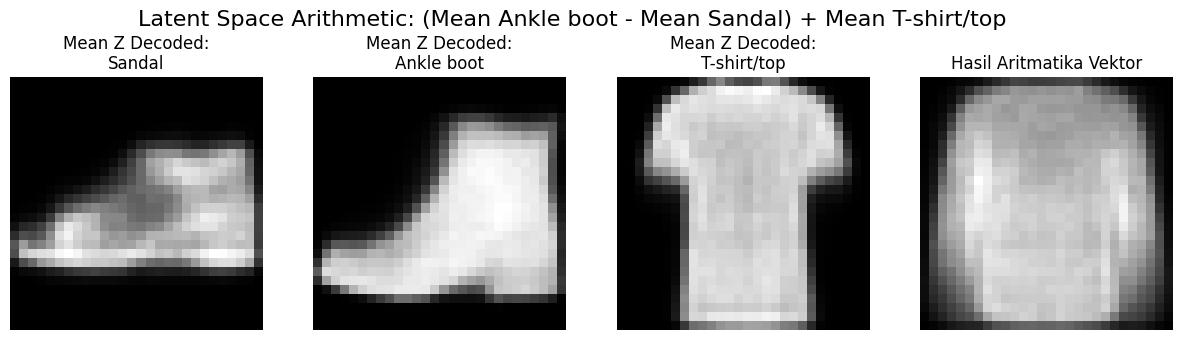


--- Perbandingan Rekonstruksi VAE vs Standard Autoencoder ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


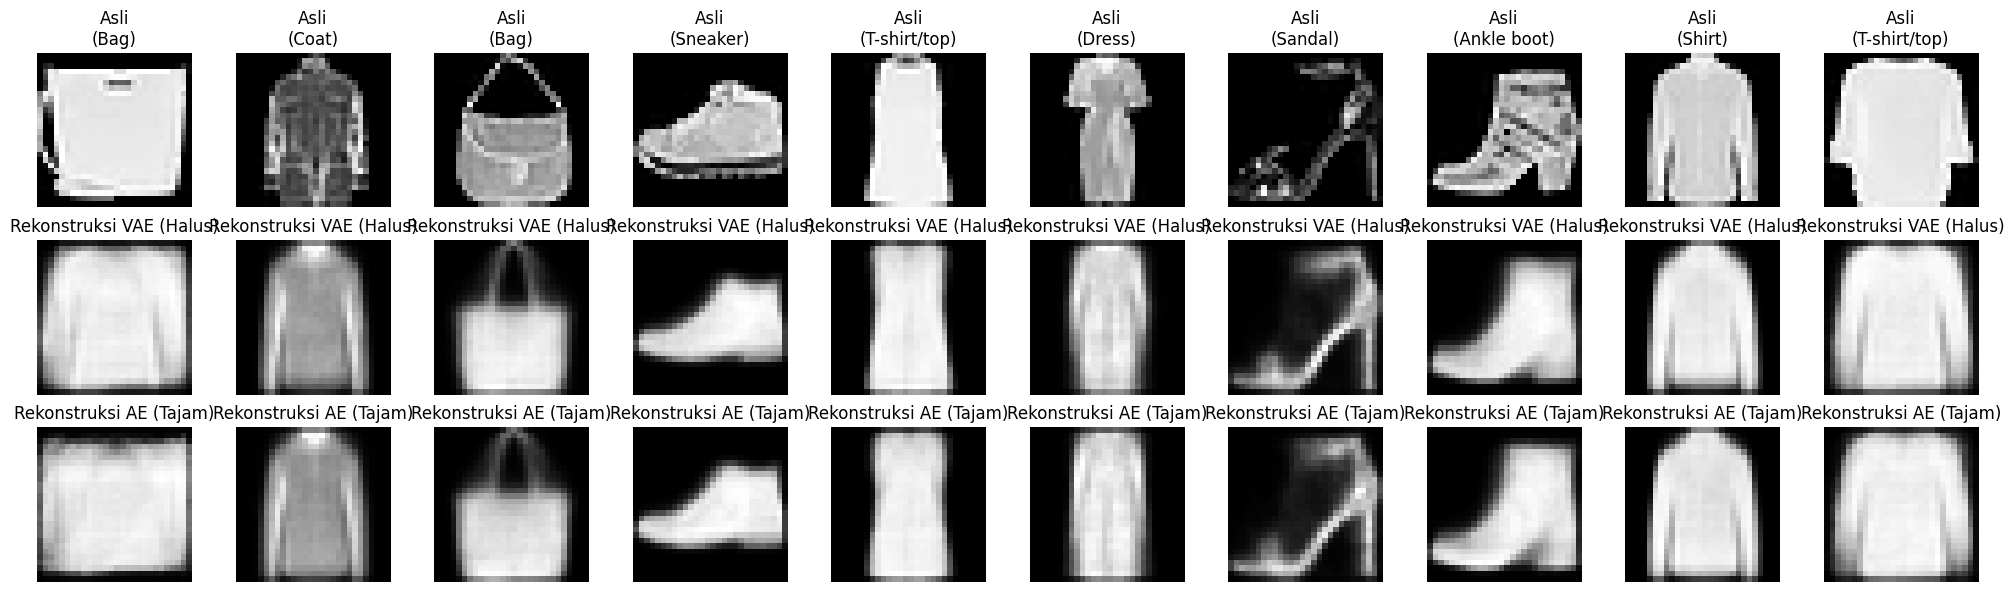


--- Eksplorasi Ruang Laten (Interpolasi Kontinu VAE) ---


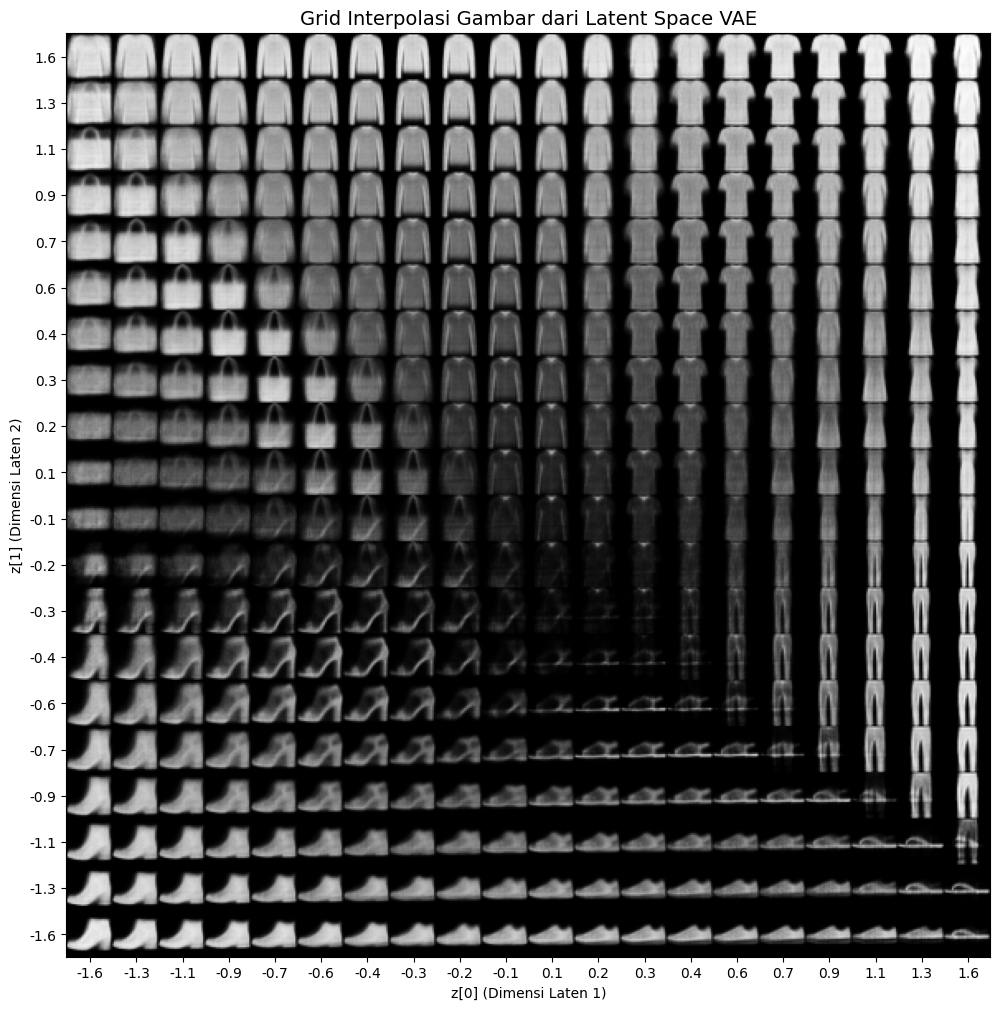

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
# Menonaktifkan logging yang berlebihan dari TensorFlow
tf.get_logger().setLevel('ERROR')

# ==============================================================================
# 1. SETUP DAN PRE-PROCESSING DATASET FASHION-MNIST
# ==============================================================================

# Mengatur parameter
ORIGINAL_DIM = 784  # 28 * 28
IMAGE_SIZE = 28
LATENT_DIM = 2  # Menggunakan dimensi 2D untuk visualisasi latent space
BATCH_SIZE = 128
EPOCHS = 25 # Kurangi epoch untuk running cepat, bisa ditingkatkan jika perlu

print("Memuat dan memproses data Fashion-MNIST...")

# Memuat dataset
(x_train, y_train), (x_test, y_test) = keras.datasets.fashion_mnist.load_data()

# Normalisasi dan Reshape ke format (jumlah_sampel, 784)
x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0
x_train = x_train.reshape((x_train.shape[0], ORIGINAL_DIM))
x_test = x_test.reshape((x_test.shape[0], ORIGINAL_DIM))

# Label kelas Fashion-MNIST
FASHION_LABELS = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
                  'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# ==============================================================================
# 2. DEFINISI KOMPONEN VAE
# ==============================================================================

# --- Layer Sampling (Reparameterization Trick) ---
class Sampling(layers.Layer):
    """
    Menggunakan (z_mean, z_log_var) untuk mengambil sampel z, vektor laten.
    """
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        # Menggunakan bentuk statis jika memungkinkan, fallback ke dinamis
        if z_mean.shape.dims:
            batch = z_mean.shape[0] if z_mean.shape[0] else tf.shape(z_mean)[0]
            dim = z_mean.shape[1] if z_mean.shape[1] else tf.shape(z_mean)[1]

        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

# --- Encoder VAE ---
def create_vae_encoder(latent_dim):
    encoder_inputs = keras.Input(shape=(ORIGINAL_DIM,), name="input_vae")
    x = layers.Dense(512, activation="relu")(encoder_inputs)
    x = layers.Dense(256, activation="relu")(x)
    z_mean = layers.Dense(latent_dim, name="z_mean")(x)
    z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
    z = Sampling()([z_mean, z_log_var])
    return keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")

# --- Decoder VAE ---
def create_vae_decoder(latent_dim):
    latent_inputs = keras.Input(shape=(latent_dim,), name="latent_input")
    x = layers.Dense(256, activation="relu")(latent_inputs)
    x = layers.Dense(512, activation="relu")(x)
    decoder_outputs = layers.Dense(ORIGINAL_DIM, activation="sigmoid")(x)
    return keras.Model(latent_inputs, decoder_outputs, name="decoder")

# --- Model VAE Penuh ---
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        if isinstance(data, tuple):
            data = data[0]

        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)

            # 1. Reconstruction Loss (Binary Cross-Entropy untuk gambar 0-1)
            reconstruction_loss = tf.reduce_mean(
                keras.losses.binary_crossentropy(data, reconstruction)
            )
            # Scaling loss by total pixels to make it comparable to total error
            reconstruction_loss *= ORIGINAL_DIM

            # 2. KL Divergence Loss
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))

            total_loss = reconstruction_loss + kl_loss

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

# ==============================================================================
# 3. DEFINISI STANDARD AUTOENCODER (AE) UNTUK PERBANDINGAN
# ==============================================================================

def create_standard_autoencoder():
    # Encoder AE
    input_img = keras.Input(shape=(ORIGINAL_DIM,), name="input_ae")
    encoded = layers.Dense(512, activation='relu')(input_img)
    encoded = layers.Dense(256, activation='relu')(encoded)
    # Layer laten tanpa mean/log_var
    latent_representation = layers.Dense(LATENT_DIM, activation='relu', name="latent_ae")(encoded)

    # Decoder AE
    decoded = layers.Dense(256, activation='relu')(latent_representation)
    decoded = layers.Dense(512, activation='relu')(decoded)
    output_img = layers.Dense(ORIGINAL_DIM, activation='sigmoid')(decoded)

    autoencoder = keras.Model(input_img, output_img, name="standard_autoencoder")
    return autoencoder

# ==============================================================================
# 4. INSTANSIASI DAN PELATIHAN MODEL
# ==============================================================================

# --- Inisialisasi Model VAE ---
vae_encoder = create_vae_encoder(LATENT_DIM)
vae_decoder = create_vae_decoder(LATENT_DIM)
vae = VAE(vae_encoder, vae_decoder)
vae.compile(optimizer=keras.optimizers.Adam())

print("\n--- Mulai Pelatihan VAE ---")
# Menggunakan data_train sebagai input dan target karena ini adalah unsupervised
vae_history = vae.fit(x_train, epochs=EPOCHS, batch_size=BATCH_SIZE, shuffle=True, verbose=0)
print("Pelatihan VAE Selesai.")

# --- Inisialisasi Model AE ---
ae = create_standard_autoencoder()
ae.compile(optimizer='adam', loss='binary_crossentropy')

print("\n--- Mulai Pelatihan Standard Autoencoder ---")
# Input dan target adalah x_train
ae_history = ae.fit(x_train, x_train, epochs=EPOCHS, batch_size=BATCH_SIZE, shuffle=True, verbose=0)
print("Pelatihan Standard Autoencoder Selesai.")


# ==============================================================================
# 5. VISUALISASI DISTRIBUSI LATENT SPACE (Tugas 2)
# ==============================================================================

print("\n--- Visualisasi Latent Space VAE ---")

def plot_latent_space(vae_encoder, x_test, y_test, batch_size):
    # Mengkodekan data uji ke ruang laten
    # Prediksi mengembalikan [z_mean, z_log_var, z], kita hanya butuh z_mean (indeks 0)
    z_mean = vae_encoder.predict(x_test, batch_size=batch_size)[0]

    plt.figure(figsize=(10, 8))
    # Scatter plot dengan warna berdasarkan label kelas
    scatter = plt.scatter(z_mean[:, 0], z_mean[:, 1], c=y_test, cmap='viridis', s=5, alpha=0.8)

    # Menambahkan legenda berdasarkan label Fashion-MNIST
    cbar = plt.colorbar(scatter)
    cbar.set_label('Kelas Fashion-MNIST', rotation=270, labelpad=15)

    # Membuat ticks untuk label kelas
    num_classes = len(FASHION_LABELS)
    bounds = np.linspace(0, num_classes, num_classes + 1)
    cbar.set_ticks((bounds[:-1] + bounds[1:]) / 2)
    cbar.set_ticklabels(FASHION_LABELS)

    plt.title('Distribusi Latent Space (2D) dari VAE (Fashion-MNIST)', fontsize=14)
    plt.xlabel("z[0] (Dimensi Laten 1)")
    plt.ylabel("z[1] (Dimensi Laten 2)")
    plt.grid(True, alpha=0.5)
    plt.show()

plot_latent_space(vae_encoder, x_test, y_test, BATCH_SIZE)


# ==============================================================================
# 6. LATENT SPACE ARITHMETIC (Tugas 3)
# ==============================================================================

print("\n--- Latent Space Arithmetic (Penjumlahan Vektor di Ruang Laten) ---")

# Kelas yang akan digunakan:
# Kelas 0: T-shirt/top, Kelas 9: Ankle boot, Kelas 5: Sandal
CLASS_A_ID, CLASS_B_ID, CLASS_C_ID = 5, 9, 0  # A: Sandal, B: Ankle boot, C: T-shirt/top

# 1. Dapatkan vektor laten untuk data uji
# Prediksi mengembalikan [z_mean, z_log_var, z], kita hanya butuh z_mean (indeks 0)
z_mean_test = vae_encoder.predict(x_test, batch_size=BATCH_SIZE)[0]

# 2. Hitung rata-rata vektor laten untuk setiap kelas
def get_class_mean_latent(class_id, z_means, y_labels):
    indices = np.where(y_labels == class_id)[0]
    return np.mean(z_means[indices], axis=0)

mean_A = get_class_mean_latent(CLASS_A_ID, z_mean_test, y_test)  # Sandal
mean_B = get_class_mean_latent(CLASS_B_ID, z_mean_test, y_test)  # Ankle boot
mean_C = get_class_mean_latent(CLASS_C_ID, z_mean_test, y_test)  # T-shirt/top

# 3. Lakukan Aritmatika: Vektor_Hasil = Mean_C + (Mean_B - Mean_A)
# Vektor (B - A) mewakili "sifat boot/menutup" dibandingkan "sifat sandal/terbuka"
vector_difference = mean_B - mean_A
new_latent_z = mean_C + vector_difference

# Dekode hasilnya (menggunakan vektor rata-rata)
reconstructed_A = vae_decoder.predict(mean_A.reshape(1, LATENT_DIM))[0]
reconstructed_B = vae_decoder.predict(mean_B.reshape(1, LATENT_DIM))[0]
reconstructed_C = vae_decoder.predict(mean_C.reshape(1, LATENT_DIM))[0]
reconstructed_arithmetic = vae_decoder.predict(new_latent_z.reshape(1, LATENT_DIM))[0]


fig, axes = plt.subplots(1, 4, figsize=(15, 4))
fig.suptitle(f'Latent Space Arithmetic: (Mean {FASHION_LABELS[CLASS_B_ID]} - Mean {FASHION_LABELS[CLASS_A_ID]}) + Mean {FASHION_LABELS[CLASS_C_ID]}', fontsize=16)

# Tampilkan Gambar 1: Sandal (A) - Mean
axes[0].imshow(reconstructed_A.reshape(IMAGE_SIZE, IMAGE_SIZE), cmap='gray')
axes[0].set_title(f'Mean Z Decoded:\n{FASHION_LABELS[CLASS_A_ID]}')
axes[0].axis('off')

# Tampilkan Gambar 2: Ankle boot (B) - Mean
axes[1].imshow(reconstructed_B.reshape(IMAGE_SIZE, IMAGE_SIZE), cmap='gray')
axes[1].set_title(f'Mean Z Decoded:\n{FASHION_LABELS[CLASS_B_ID]}')
axes[1].axis('off')

# Tampilkan Gambar 3: T-shirt/top (C) - Mean
axes[2].imshow(reconstructed_C.reshape(IMAGE_SIZE, IMAGE_SIZE), cmap='gray')
axes[2].set_title(f'Mean Z Decoded:\n{FASHION_LABELS[CLASS_C_ID]}')
axes[2].axis('off')

# Tampilkan Gambar 4: Hasil Aritmatika
axes[3].imshow(reconstructed_arithmetic.reshape(IMAGE_SIZE, IMAGE_SIZE), cmap='gray')
axes[3].set_title('Hasil Aritmatika Vektor')
axes[3].axis('off')

plt.show()

# ==============================================================================
# 7. PERBANDINGAN REKONSTRUKSI (Tugas 4)
# ==============================================================================

print("\n--- Perbandingan Rekonstruksi VAE vs Standard Autoencoder ---")

# Ambil sampel acak dari data uji
n_samples = 10
indices = np.random.choice(len(x_test), n_samples, replace=False)
sample_images = x_test[indices]
sample_labels = y_test[indices]

# Rekonstruksi oleh VAE
# Pastikan prediksi VAE hanya mengambil output rekonstruksi dari decoder
# VAE.predict(data) akan menjalankan encoder dan decoder secara internal
vae_reconstructions = vae.decoder(vae.encoder(sample_images)[2]).numpy()

# Rekonstruksi oleh Standard AE
ae_reconstructions = ae.predict(sample_images, batch_size=n_samples)

# Fungsi untuk menampilkan gambar
def plot_comparison(originals, vae_recon, ae_recon, labels, n=10):
    plt.figure(figsize=(20, 6))
    for i in range(n):
        # Asli
        ax = plt.subplot(3, n, i + 1)
        plt.imshow(originals[i].reshape(IMAGE_SIZE, IMAGE_SIZE), cmap='gray')
        plt.title(f"Asli\n({FASHION_LABELS[labels[i]]})")
        plt.axis("off")

        # Rekonstruksi VAE
        ax = plt.subplot(3, n, i + 1 + n)
        plt.imshow(vae_recon[i].reshape(IMAGE_SIZE, IMAGE_SIZE), cmap='gray')
        plt.title("Rekonstruksi VAE (Halus)")
        plt.axis("off")

        # Rekonstruksi AE
        ax = plt.subplot(3, n, i + 1 + 2 * n)
        plt.imshow(ae_recon[i].reshape(IMAGE_SIZE, IMAGE_SIZE), cmap='gray')
        plt.title("Rekonstruksi AE (Tajam)")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

plot_comparison(sample_images, vae_reconstructions, ae_reconstructions, sample_labels, n=n_samples)


# ==============================================================================
# 8. EKSPLORASI RUANG LATEN (Interpolasi VAE)
# ==============================================================================

print("\n--- Eksplorasi Ruang Laten (Interpolasi Kontinu VAE) ---")

# Membuat grid dari ruang laten (hanya VAE yang mampu interpolasi mulus)
n_grids = 20
# Mengambil nilai dari distribusi Gaussian (norm.ppf)
grid_x = norm.ppf(np.linspace(0.05, 0.95, n_grids))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n_grids))
figure = np.zeros((IMAGE_SIZE * n_grids, IMAGE_SIZE * n_grids))

# Dekode setiap titik pada grid
for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = vae_decoder.predict(z_sample, verbose=0)
        digit = x_decoded[0].reshape(IMAGE_SIZE, IMAGE_SIZE)
        figure[(n_grids - 1 - i) * IMAGE_SIZE: (n_grids - i) * IMAGE_SIZE, # Membalik sumbu Y untuk visualisasi yang lebih baik
               j * IMAGE_SIZE: (j + 1) * IMAGE_SIZE] = digit

plt.figure(figsize=(12, 12))
plt.title('Grid Interpolasi Gambar dari Latent Space VAE', fontsize=14)
start_offset = IMAGE_SIZE // 2

# FIX: Menghitung pixel_range dengan tepat untuk memastikan 20 lokasi tick
# np.arange(n_grids) menghasilkan [0, 1, ..., 19] (20 elemen)
# Ketika dikalikan IMAGE_SIZE dan ditambah offset, hasilnya adalah 20 lokasi tick
pixel_range = np.arange(n_grids) * IMAGE_SIZE + start_offset

# Label untuk sumbu
sample_range_x = np.round(grid_x, 1)
sample_range_y = np.round(grid_y[::-1], 1) # Membalik label sumbu Y agar sesuai dengan pembalikan gambar

plt.xticks(pixel_range, sample_range_x)
plt.yticks(pixel_range, sample_range_y)

plt.xlabel("z[0] (Dimensi Laten 1)")
plt.ylabel("z[1] (Dimensi Laten 2)")
plt.imshow(figure, cmap='gray')
plt.show()